In [103]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import sidetable

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import StandardScaler

#from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Calidad de los clusters
# ==============================================================================
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from matplotlib import axes, pyplot, lines
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (18,15)

### Abrimos nuestro CSV 

In [66]:
df_nba1 = pd.read_csv('2021-2022 NBA Player Stats - Regular.csv', encoding='latin1', sep=';')
df_nba1

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,0.8,2.1,0.359,2.9,6.1,0.468,0.486,1.1,1.8,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,0.547,0.0,0.0,0.000,2.8,5.0,0.548,0.547,1.4,2.6,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,0.557,0.0,0.1,0.000,7.3,12.9,0.562,0.557,4.6,6.1,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,0.2,1.5,0.125,1.5,2.6,0.560,0.424,0.6,1.0,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,0.550,0.3,1.0,0.304,5.1,8.8,0.578,0.566,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,5.5,0.465,0.7,1.7,0.395,1.9,3.9,0.495,0.524,0.5,1.0,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
808,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,0.460,3.1,8.0,0.382,6.3,12.3,0.512,0.536,6.6,7.3,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
809,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.526,0.0,0.2,0.091,2.3,4.2,0.547,0.528,0.7,1.1,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
810,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.567,0.0,0.1,0.000,1.9,3.2,0.593,0.567,1.4,1.8,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


## ¿Qué información contiene nuestro CSV?

- **RK** - Ranking de los jugadores. Del 1 al 605 porque hay algún jugador que se repite más de una vez.
- **Player** - Nombre del jugador.
- **Pos** - Posición del jugador. Los principales son:
     - **PG** - Point Guard. ***Base*** es el jugador que maneja el balón. Su posición suele estar en la línea de triples. Destaca en asistencias, robos de balón y tiros triples.
     - **SG** - Shooting Guard. ***Escolta*** como su propio nombre indica es el jugador que ayuda al base (a veces cambian de posición en el propio partido).
     - **SF** - Small Forward. ***Alero***
     - **PF** - Power Forward. ***Ala-pivot***
     - **C** - Center. ***Pivot***. Se coloca debajo de canasta, suele ser un jugador alto. Destaca en rebotes, tiros dobles o tiros debajo de canasta, bloqueos y tapones.
- **Age** - Edad del jugador.
- **Tm** - Equipo del jugador.
- **G** - Partidos jugados.
- **GS** - Partidos iniciados en el equipo.
- **MP** - Minutos jugados.
- **FG** - Tiros de campo.
- **FGA** - Intentos de tiros de campo.
- **FG%** - Porcentaje de tiros de campo. Esta medida sirve para diferenciar el acierto respecto a los tiros de campo totales intentados.
- **3P** - Tiros de 3 puntos. Tiros triples. Se tiran desde detrás de la línea elíptica.
- **3PA** - Intentos de tiros de 3 puntos.
- **3P%** - Porcentaje de tiros de 3 puntos.
- **2P** - Tiros de 2 puntos. Tiros dobles.
- **2PA** - Intentos de tiros de 2 puntos.
- **2P%** - Porcentaje de tiros de 2 puntos.
- **eFG%** - Porcentaje de efectividad de tiros de campo. Esta estadística recoge el acierto en el tiro dándole un punto más a los triples respecto a los tiros de dos.
- **FT** - Tiros libres. Se tiran cuando un jugador del equipo contrario le hacen falta.
- **FTA** - Intentos de tiros libres.
- **FT%** - Porcentaje de tiros libres.   
- **ORB** - Rebotes ofensivos. Es cuando se coge el balón después de un tiro a canasta y el rebote lo coge otro jugador del mismo equipo atacante. La cantidad de rebotes ofensivos capturados sobre el total disponible por un jugador o equipo.
- **DRB** - Rebotes defensivos. Es cuando se coge el balón después de un tiro a canasta y el rebote lo coge un jugador del equipo defensor. Esta estadística es la cantidad de rebotes defensivos capturados sobre el total disponible por un jugador o equipo.
- **TRB** - Rebotes totales. 
- **AST** - Asistencias. Es un pase que da lugar a una canasta.
- **STL** - Robos. Un jugador le quita el balón a otro.
- **BLK** - Bloqueos. ES un gesto técnico que realiza un jugador atacante mediante el cual y con el uso de su propio cuerpo, permite a un compañero obtener ventaja sobre su defensor.
- **TOV** - Perdidas de balón.
- **PF** - Faltas personales.
- **PTS** - Total de puntos.

### Cambiaremos el nombre de las columnas para que sean más explicativas y nos ayude al estudio del CSV.

In [67]:
df_nba1.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [68]:
df_nba1.rename(columns= {"Rk":"rango","Player":"jugador","Pos":"posicion","Age":"edad","Tm":"equipo",
                                    "G":"partidos_jugados", "GS":"partidos_iniciados", "MP":"minutos_jugados",
                                    "FG":"tiros_campo", "FGA":"intentos_campo","FG%":"tiros_campo_porc", 
                                    "3P":"tiros_triples", "3PA":"intentos_triple", 
                                    "3P%":"triples_porc", "2P":"tiros_dobles","2PA":"intentos_dobles", 
                                    "2P%":"dobles_porc", "eFG%":"tiros_efectivo_porc", "FT":"tiros_libres",
                                    "FTA":"intentos_tiros_libres",'FT%':"tiros_libres_porc", 'ORB':"rebotes_ofensivos",
                                    "DRB":"rebotes_defensivos","TRB":"total_rebotes","AST":"asistencias",
                                    "STL":"robos","BLK":"bloqueos","TOV":"perdidas_balon","PF":"faltas_personales",
                                    "PTS":"total_puntos"
                                    },inplace=True)
df_nba1.columns

Index(['rango', 'jugador', 'posicion', 'edad', 'equipo', 'partidos_jugados',
       'partidos_iniciados', 'minutos_jugados', 'tiros_campo',
       'intentos_campo', 'tiros_campo_porc', 'tiros_triples',
       'intentos_triple', 'triples_porc', 'tiros_dobles', 'intentos_dobles',
       'dobles_porc', 'tiros_efectivo_porc', 'tiros_libres',
       'intentos_tiros_libres', 'tiros_libres_porc', 'rebotes_ofensivos',
       'rebotes_defensivos', 'total_rebotes', 'asistencias', 'robos',
       'bloqueos', 'perdidas_balon', 'faltas_personales', 'total_puntos'],
      dtype='object')

### Guardamos el CSV

In [69]:
df_nba1.to_csv('nba_regionales.csv')

### Ideas

- Crear columnas de porcentajes de por ejemplo: total rebotes, bloqueos, asistencias...
- Buscar datos de altura y salario
- Cambiar nombre de jugadores, equipo y posición
- Hacer una regresión. Probar con cual se ajusta mejor.

In [70]:
df_nba = pd.read_csv('nba_regionales.csv', index_col=0)

In [71]:
df_nba

,rango,jugador,posicion,edad,equipo,partidos_jugados,partidos_iniciados,minutos_jugados,tiros_campo,intentos_campo,tiros_campo_porc,tiros_triples,intentos_triple,triples_porc,tiros_dobles,intentos_dobles,dobles_porc,tiros_efectivo_porc,tiros_libres,intentos_tiros_libres,tiros_libres_porc,rebotes_ofensivos,rebotes_defensivos,total_rebotes,asistencias,robos,bloqueos,perdidas_balon,faltas_personales,total_puntos
0,1,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,0.8,2.1,0.359,2.9,6.1,0.468,0.486,1.1,1.8,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,0.547,0.0,0.0,0.000,2.8,5.0,0.548,0.547,1.4,2.6,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,0.557,0.0,0.1,0.000,7.3,12.9,0.562,0.557,4.6,6.1,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,0.2,1.5,0.125,1.5,2.6,0.560,0.424,0.6,1.0,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,0.550,0.3,1.0,0.304,5.1,8.8,0.578,0.566,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,5.5,0.465,0.7,1.7,0.395,1.9,3.9,0.495,0.524,0.5,1.0,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
808,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,0.460,3.1,8.0,0.382,6.3,12.3,0.512,0.536,6.6,7.3,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
809,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.526,0.0,0.2,0.091,2.3,4.2,0.547,0.528,0.7,1.1,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
810,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.567,0.0,0.1,0.000,1.9,3.2,0.593,0.567,1.4,1.8,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


### Análisis Exploratorio

In [72]:
df_nba.shape

(812, 30)

In [73]:
df_nba.rango.value_counts()

386    5
535    4
538    4
180    4
163    4
      ..
207    1
206    1
205    1
204    1
605    1
Name: rango, Length: 605, dtype: int64

In [74]:
df_nba.describe().T

,count,mean,std,min,25%,50%,75%,max
rango,812.0,304.501232,172.637333,1.0,158.75000,300.5000,459.00000,605.0
edad,812.0,26.051724,4.059640,19.0,23.00000,25.0000,29.00000,41.0
partidos_jugados,812.0,36.704433,25.899099,1.0,12.00000,36.5000,61.00000,82.0
partidos_iniciados,812.0,16.672414,23.817195,0.0,0.00000,4.0000,25.00000,82.0
minutos_jugados,812.0,18.265394,9.648292,1.0,10.50000,17.5000,25.72500,43.5
tiros_campo,812.0,2.869951,2.223988,0.0,1.20000,2.4000,3.90000,11.4
intentos_campo,812.0,6.386576,4.651121,0.0,3.00000,5.1500,8.72500,21.8
tiros_campo_porc,812.0,0.426235,0.148525,0.0,0.38075,0.4395,0.50000,1.0
tiros_triples,812.0,0.871305,0.841935,0.0,0.20000,0.7000,1.40000,4.5
intentos_triple,812.0,2.560591,2.205642,0.0,0.80000,2.0500,3.90000,11.7


- El mínimo de edad es 19 y el máximo 41. La edad media de retirada de los jugadores es de 32. 
- En todas las variables hay algún o algunos jugadores que tienen de media 0 pts.
- En partidos jugados y minutos jugados se ve que todos han jugado.

In [75]:
df_nba.stb.missing()

,missing,total,percent
rango,0,812,0.0
jugador,0,812,0.0
faltas_personales,0,812,0.0
perdidas_balon,0,812,0.0
bloqueos,0,812,0.0
robos,0,812,0.0
asistencias,0,812,0.0
total_rebotes,0,812,0.0
rebotes_defensivos,0,812,0.0
rebotes_ofensivos,0,812,0.0


- **No hay valores nulos**, el dataset está bastante limpio. Veamos los outliers:

In [76]:
df_nba.dtypes

rango                      int64
jugador                   object
posicion                  object
edad                       int64
equipo                    object
partidos_jugados           int64
partidos_iniciados         int64
minutos_jugados          float64
tiros_campo              float64
intentos_campo           float64
tiros_campo_porc         float64
tiros_triples            float64
intentos_triple          float64
triples_porc             float64
tiros_dobles             float64
intentos_dobles          float64
dobles_porc              float64
tiros_efectivo_porc      float64
tiros_libres             float64
intentos_tiros_libres    float64
tiros_libres_porc        float64
rebotes_ofensivos        float64
rebotes_defensivos       float64
total_rebotes            float64
asistencias              float64
robos                    float64
bloqueos                 float64
perdidas_balon           float64
faltas_personales        float64
total_puntos             float64
dtype: obj

- Solo tenemos tres variables categóricas.

In [77]:
numericas = df_nba.select_dtypes(include=np.number)

In [78]:
numericas.shape

(812, 27)

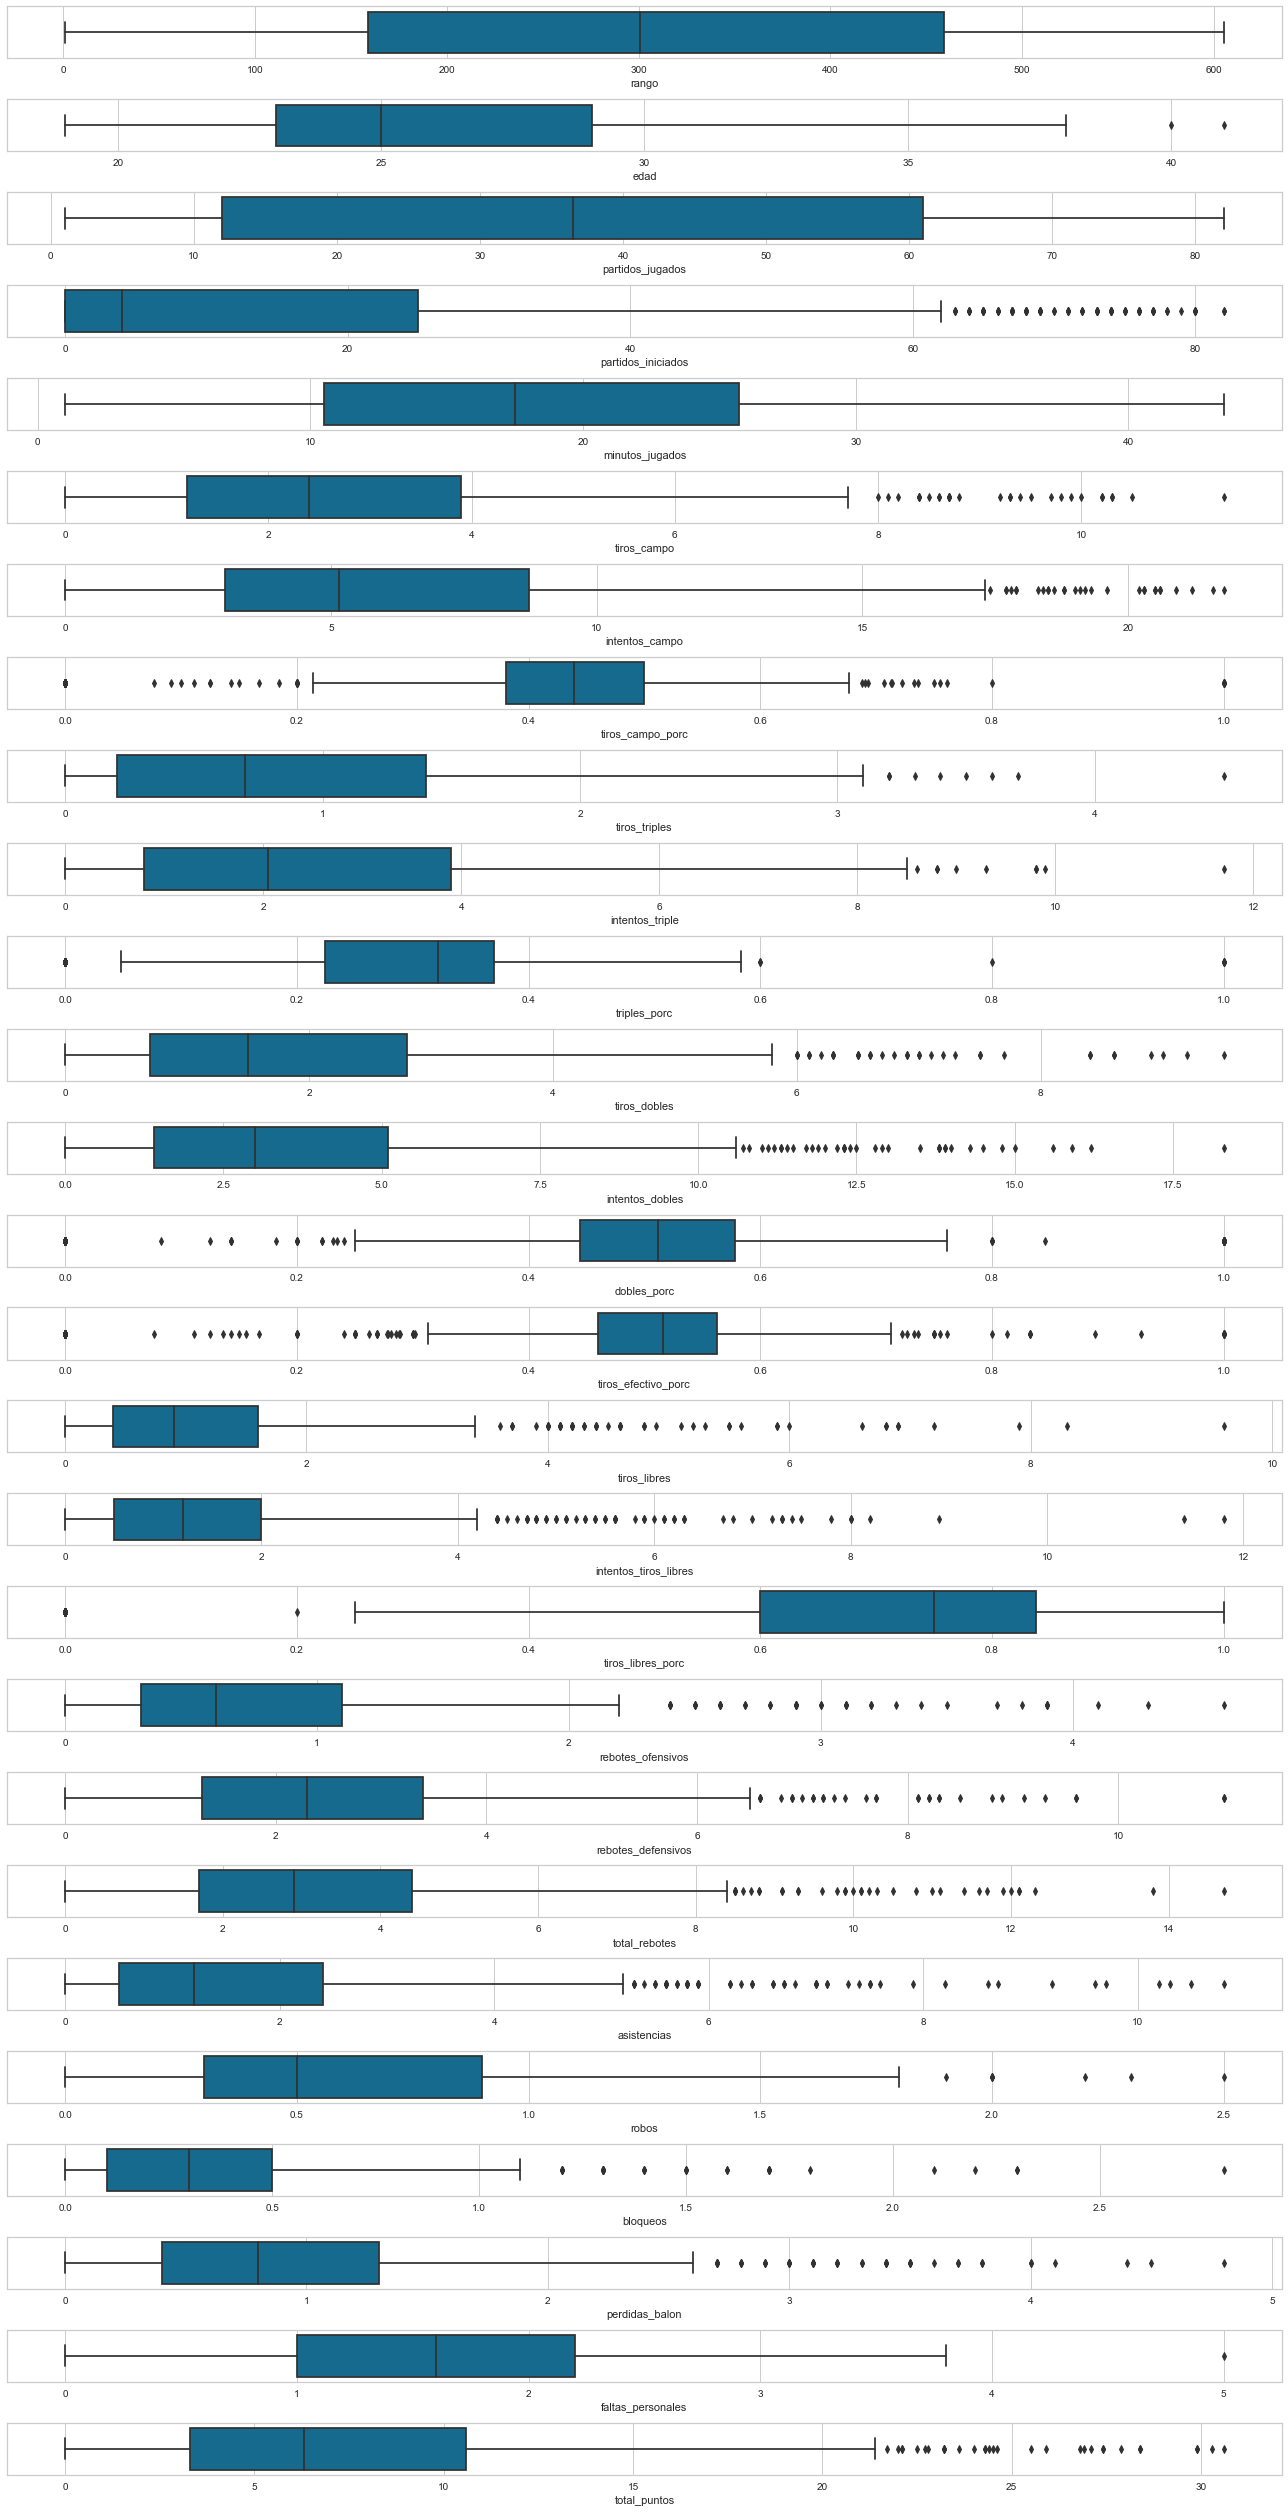

In [79]:
fig, axes = plt.subplots(27, 1, figsize=(18,35))

for i, col in enumerate(numericas.columns):
    sns.boxplot(x = numericas.columns[i], data = df_nba, ax=axes[i]); # para trazar una línea de densidad

plt.tight_layout()

plt.show()

- **No reemplazaré ningún outlier** porque todos pueden ser importantes. Ya que serán los mejores y 'peores' jugadores de la temporada.

In [80]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df_nba[col], 25)
        Q3 = np.nanpercentile(df_nba[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 

In [81]:
lista_columnas = list(numericas.columns)
indices = detectar_outliers(lista_columnas, df_nba)

In [82]:
#indices

In [83]:
df_nba

,rango,jugador,posicion,edad,equipo,partidos_jugados,partidos_iniciados,minutos_jugados,tiros_campo,intentos_campo,tiros_campo_porc,tiros_triples,intentos_triple,triples_porc,tiros_dobles,intentos_dobles,dobles_porc,tiros_efectivo_porc,tiros_libres,intentos_tiros_libres,tiros_libres_porc,rebotes_ofensivos,rebotes_defensivos,total_rebotes,asistencias,robos,bloqueos,perdidas_balon,faltas_personales,total_puntos
0,1,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,0.8,2.1,0.359,2.9,6.1,0.468,0.486,1.1,1.8,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,0.547,0.0,0.0,0.000,2.8,5.0,0.548,0.547,1.4,2.6,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,0.557,0.0,0.1,0.000,7.3,12.9,0.562,0.557,4.6,6.1,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,0.2,1.5,0.125,1.5,2.6,0.560,0.424,0.6,1.0,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,0.550,0.3,1.0,0.304,5.1,8.8,0.578,0.566,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,5.5,0.465,0.7,1.7,0.395,1.9,3.9,0.495,0.524,0.5,1.0,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
808,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,0.460,3.1,8.0,0.382,6.3,12.3,0.512,0.536,6.6,7.3,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
809,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.526,0.0,0.2,0.091,2.3,4.2,0.547,0.528,0.7,1.1,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
810,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,0.567,0.0,0.1,0.000,1.9,3.2,0.593,0.567,1.4,1.8,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


Veamos si hay duplicados

In [84]:
df_nba.duplicated().sum() 

0

Como hemos dicho antes, es un df bastante limpio

- Cambiaremos el nombre de los jugadores a minúsculas y '_' para no tener problemas a la hora de trabajar con ellos.

In [85]:
df_nba_cambios= df_nba.copy()

In [86]:
def minusculas(df):
    for indice in range(len(df)):
        try:
            df[indice] = df[indice].replace(" ", "_").lower()

        except:
            pass

    
minusculas(df_nba_cambios['jugador'])

In [87]:
pd.options.display.max_columns = None #para que aparezcan todas las columnas
df_nba_cambios

,rango,jugador,posicion,edad,equipo,partidos_jugados,partidos_iniciados,minutos_jugados,tiros_campo,intentos_campo,tiros_campo_porc,tiros_triples,intentos_triple,triples_porc,tiros_dobles,intentos_dobles,dobles_porc,tiros_efectivo_porc,tiros_libres,intentos_tiros_libres,tiros_libres_porc,rebotes_ofensivos,rebotes_defensivos,total_rebotes,asistencias,robos,bloqueos,perdidas_balon,faltas_personales,total_puntos
0,1,precious_achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,0.8,2.1,0.359,2.9,6.1,0.468,0.486,1.1,1.8,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,steven_adams,C,28,MEM,76,75,26.3,2.8,5.1,0.547,0.0,0.0,0.000,2.8,5.0,0.548,0.547,1.4,2.6,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,bam_adebayo,C,24,MIA,56,56,32.6,7.3,13.0,0.557,0.0,0.1,0.000,7.3,12.9,0.562,0.557,4.6,6.1,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,santi_aldama,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,0.2,1.5,0.125,1.5,2.6,0.560,0.424,0.6,1.0,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,lamarcus_aldridge,C,36,BRK,47,12,22.3,5.4,9.7,0.550,0.3,1.0,0.304,5.1,8.8,0.578,0.566,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,thaddeus_young,PF,33,TOR,26,0,18.3,2.6,5.5,0.465,0.7,1.7,0.395,1.9,3.9,0.495,0.524,0.5,1.0,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
808,602,trae_young,PG,23,ATL,76,76,34.9,9.4,20.3,0.460,3.1,8.0,0.382,6.3,12.3,0.512,0.536,6.6,7.3,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
809,603,omer_yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.526,0.0,0.2,0.091,2.3,4.2,0.547,0.528,0.7,1.1,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
810,604,cody_zeller,C,29,POR,27,0,13.1,1.9,3.3,0.567,0.0,0.1,0.000,1.9,3.2,0.593,0.567,1.4,1.8,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


### Correlación entre las variables

In [88]:
df_nba_cambios.corr()

,rango,edad,partidos_jugados,partidos_iniciados,minutos_jugados,tiros_campo,intentos_campo,tiros_campo_porc,tiros_triples,intentos_triple,triples_porc,tiros_dobles,intentos_dobles,dobles_porc,tiros_efectivo_porc,tiros_libres,intentos_tiros_libres,tiros_libres_porc,rebotes_ofensivos,rebotes_defensivos,total_rebotes,asistencias,robos,bloqueos,perdidas_balon,faltas_personales,total_puntos
rango,1.000000,-0.037216,-0.066503,-0.086550,-0.050971,-0.057393,-0.054080,-0.001554,-0.052654,-0.052840,0.016625,-0.045805,-0.042180,-0.003819,0.001523,-0.044115,-0.043843,-0.017262,-0.030168,-0.079571,-0.070434,0.006615,-0.015441,-0.017137,-0.020534,0.000567,-0.057467
edad,-0.037216,1.000000,0.042212,0.052232,0.145388,0.087947,0.085564,0.059665,0.121144,0.104885,0.084448,0.053645,0.052922,0.051634,0.083222,0.070301,0.052197,0.075038,0.014226,0.124140,0.099501,0.171731,0.072693,0.038176,0.096063,0.127838,0.094685
partidos_jugados,-0.066503,0.042212,1.000000,0.680436,0.620290,0.563977,0.542432,0.311718,0.475981,0.457740,0.372137,0.484188,0.473385,0.285804,0.361020,0.405123,0.406731,0.468275,0.293125,0.517411,0.487806,0.387040,0.424368,0.336577,0.424739,0.470319,0.559330
partidos_iniciados,-0.086550,0.052232,0.680436,1.000000,0.751435,0.736394,0.713715,0.226771,0.530903,0.524531,0.226564,0.674423,0.676920,0.185241,0.239448,0.598500,0.601263,0.288935,0.354654,0.656365,0.612579,0.563921,0.521898,0.408970,0.617675,0.538844,0.732292
minutos_jugados,-0.050971,0.145388,0.620290,0.751435,1.000000,0.886895,0.898603,0.299632,0.720450,0.732635,0.417982,0.773570,0.803061,0.256953,0.360893,0.696602,0.692933,0.496879,0.357061,0.756131,0.688470,0.728131,0.717810,0.447035,0.771405,0.743587,0.887411
tiros_campo,-0.057393,0.087947,0.563977,0.736394,0.886895,1.000000,0.970853,0.355639,0.679117,0.680076,0.352440,0.936068,0.944519,0.288871,0.370473,0.820781,0.820764,0.425511,0.383116,0.764754,0.703036,0.707715,0.617590,0.447414,0.811092,0.651883,0.989932
intentos_campo,-0.054080,0.085564,0.542432,0.713715,0.898603,0.970853,1.000000,0.211332,0.764839,0.794470,0.367820,0.858461,0.907912,0.176087,0.255470,0.798048,0.783724,0.437638,0.257649,0.697697,0.612265,0.744193,0.637838,0.358791,0.824847,0.616042,0.975918
tiros_campo_porc,-0.001554,0.059665,0.311718,0.226771,0.299632,0.355639,0.211332,1.000000,0.053493,-0.018902,0.221204,0.423169,0.320742,0.849532,0.953627,0.230984,0.265083,0.260330,0.436072,0.372291,0.421290,0.109928,0.171141,0.387849,0.199539,0.395070,0.313305
tiros_triples,-0.052654,0.121144,0.475981,0.530903,0.720450,0.679117,0.764839,0.053493,1.000000,0.969827,0.550784,0.378097,0.444392,0.064877,0.242413,0.478165,0.428949,0.436182,-0.115142,0.359467,0.237293,0.539793,0.506564,0.092254,0.540044,0.381334,0.729547
intentos_triple,-0.052840,0.104885,0.457740,0.524531,0.732635,0.680076,0.794470,-0.018902,0.969827,1.000000,0.470174,0.393432,0.466905,0.045527,0.155397,0.489752,0.440304,0.415277,-0.127942,0.369933,0.241032,0.564140,0.518342,0.087548,0.572415,0.386590,0.728704


- Aquí vemos la correlación entre cada una de las variables:
    - A simple vista vemos que la variable de *rango* ***apenas tiene correlación*** con ninguna y a medida que pasamos las varaibles, más correlación tienen. 
    - La variable de *total_puntos*, en cambio, es la que ***más relación tiene*** con las demás.

Pero esto lo podemos ver mejor con un **heatmap**(mapa de calor)

In [89]:
# creamos un dataframe todo de unos de la misma forma que nuestra matriz de correlación
mask = np.triu(np.ones_like(df_nba_cambios.corr(), dtype=np.bool))

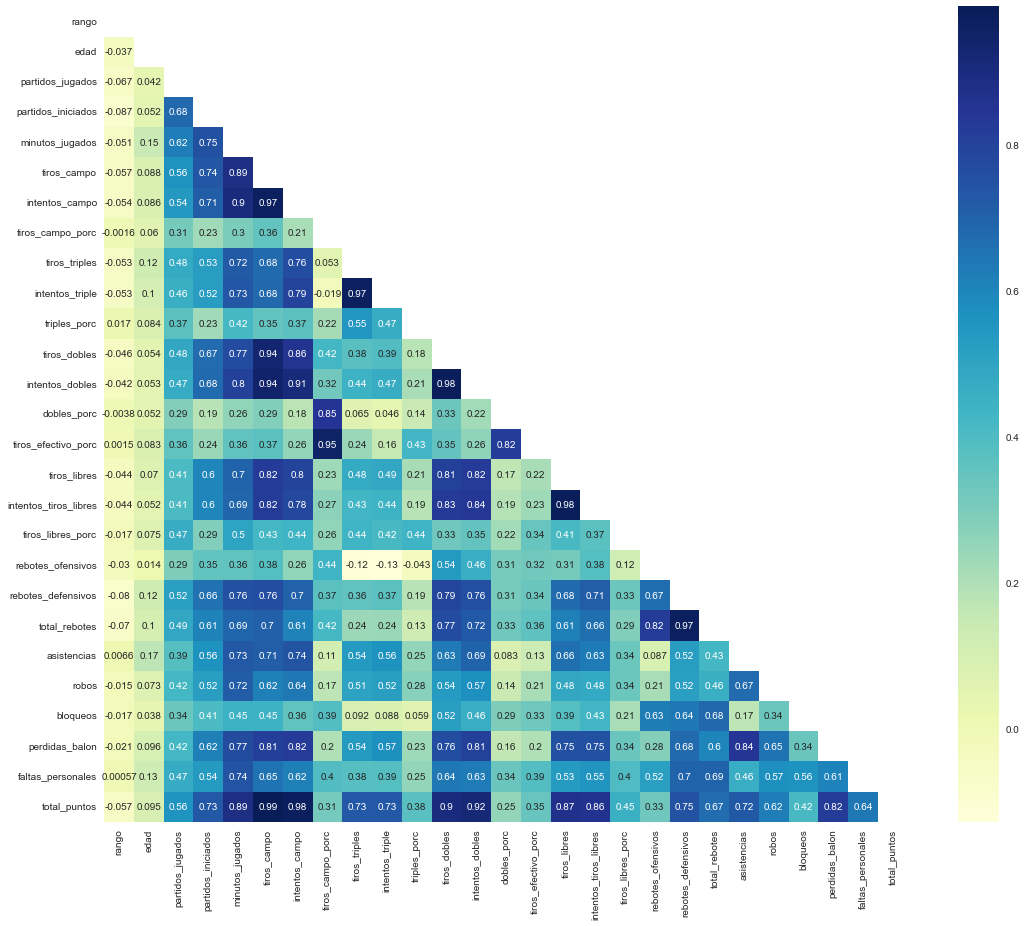

In [90]:
sns.heatmap(df_nba_cambios.corr(),
            cmap = "YlGnBu", # para cambiar el color
            mask = mask, 
            annot = True); # para sacar el valor de la correlación

- En esta gráfica podemos ver mejor como los colores de azul más oscuros son los que la correlación entre esas variables es fuerte y positiva, ya que son mas de 0.7/0.8. Por ejemplo: ***intentos_tiros_dobles*** y ***tiros_dobles***, tiene sentido ya que cuanto más intentos, más encestos.
- Las que tienen una correlación baja y negativa son los colores de azul casi blanco como podemos ver en ***bloqueos*** y ***edad***.

## Modelo de clusterización

El término **clustering** hace referencia a un amplio abanico de técnicas cuya finalidad es **encontrar patrones o grupos (clusters) dentro de un conjunto de observaciones**. Las particiones se establecen de forma que, las observaciones que están dentro de un mismo grupo, son similares entre ellas y distintas a las observaciones de otros grupos.

Pueden diferenciarse tres grupos principales:

- **Partitioning Clustering:** este tipo de algoritmos requieren que el usuario especifique de antemano el número de clusters que se van a crear (K-means, K-medoids, CLARA).

- **Hierarchical Clustering:** este tipo de algoritmos no requieren que el usuario especifique de antemano el número de clusters. (agglomerative clustering, divisive clustering).

- **Métodos que combinan o modifican los anteriores** (hierarchical K-means, fuzzy clustering, model based clustering y density based clustering).

## K-Means

Lo primero que tenemos que hacer es determinar el número de clusters que utilizaremos. Podremos usar dos aproximaciones:

- **Usando la inercia**: mide lo bien que un conjunto de datos fue agrupado por K-Means. Se calcula midiendo la distancia entre cada punto de datos y su centroide, elevando al cuadrado esta distancia y sumando estos cuadrados en un clúster.

    - Un buen modelo es el que tiene una baja inercia y un bajo número de clusters (K). Sin embargo, se trata de un compromiso, ya que a medida que K aumenta, la inercia disminuye.

    - Para encontrar la K óptima para un conjunto de datos, utilizaremos el método del codo; el cual encuentra el punto en el que la disminución de la inercia comienza a disminuir.

- **Usando el silhouette:** indica la distancia entre los puntos de datos de un grupo y los de otro grupo. El rango de la puntuación de la silueta es de -1 a 1. La puntuación debe estar más cerca de 1 que de -1.

    - Cuánto más cerca de 1 significa que el cluster está bien configurado, es decir, los datos dentro de un cluster son muy similares

    - Cuánto más cerca de -1 significa que el cluster está mal configurado, es decir, los datos dentro del cluster son muy diferentes, lo que hace que los puntos estén más separados y, por lo tanto, más cerca estarán los clusters

## Estandarizamos variables numericas

In [91]:
df_nba_numerica = df_nba_cambios.select_dtypes(include=np.number)

In [92]:
st = StandardScaler()
df_estandarizado = pd.DataFrame(st.fit_transform(df_nba_numerica), columns=df_nba_numerica.columns)
df_estandarizado.head()

,rango,edad,partidos_jugados,partidos_iniciados,minutos_jugados,tiros_campo,intentos_campo,tiros_campo_porc,tiros_triples,intentos_triple,triples_porc,tiros_dobles,intentos_dobles,dobles_porc,tiros_efectivo_porc,tiros_libres,intentos_tiros_libres,tiros_libres_porc,rebotes_ofensivos,rebotes_defensivos,total_rebotes,asistencias,robos,bloqueos,perdidas_balon,faltas_personales,total_puntos
0,-1.759111,-0.998665,1.402286,0.475899,0.553248,0.328464,0.411643,0.085997,-0.084744,-0.208953,0.523628,0.510882,0.711836,-0.111353,-0.014715,-0.081132,0.141808,-0.223310,1.596086,1.106518,1.347449,-0.385559,-0.194639,0.683406,0.270731,0.647902,0.209896
1,-1.753315,0.480209,1.518191,2.450479,0.833262,-0.031472,-0.276787,0.813597,-1.035522,-1.161643,-1.756004,0.454109,0.367092,0.332040,0.376727,0.151932,0.646566,-0.406850,5.091942,1.609437,2.835943,0.866518,0.746117,1.238055,0.637731,0.526877,-0.148744
2,-1.747519,-0.505707,0.745488,1.652244,1.486630,1.993167,1.422775,0.880967,-1.035522,-1.116277,-1.756004,3.008867,2.842983,0.409634,0.440897,2.637953,2.854884,0.334371,2.133910,2.838794,2.878472,0.866518,1.922062,1.238055,1.983400,1.858155,1.840075
3,-1.741723,-1.245144,-0.181757,-0.700447,-0.722375,-0.526384,-0.491921,-0.163274,-0.797828,-0.481150,-0.962260,-0.283932,-0.385078,0.398549,-0.412574,-0.469573,-0.362950,-0.117421,0.251525,-0.458119,-0.268631,-0.603311,-0.900206,-0.148567,-0.585604,-0.562350,-0.605194
4,-1.735927,2.452042,0.397771,-0.196299,0.418426,1.138319,0.712832,0.833808,-0.678980,-0.707981,0.174381,1.759874,1.558027,0.498313,0.498651,0.540373,0.394187,0.757926,1.058262,0.771239,0.922165,-0.494435,-0.665017,1.792703,-0.096270,0.163801,0.829364


Un vez estandarizadas, pasamos a implementar el modelo **KMeans** separando por **6 clusters** y lo verificaremos con **silhoutte**.

In [93]:
km_6 = KMeans(n_clusters=6)
km_6.fit(df_estandarizado)

KMeans(n_clusters=6)

In [94]:
y_pred_6 = km_6.predict(df_estandarizado)
y_pred_6

array([4, 4, 5, 1, 4, 0, 3, 1, 0, 5, 0, 0, 1, 0, 0, 5, 1, 0, 3, 3, 1, 1,
       1, 1, 1, 0, 2, 5, 4, 4, 4, 4, 3, 3, 4, 3, 1, 2, 3, 3, 3, 3, 1, 1,
       0, 0, 1, 4, 5, 0, 2, 0, 0, 2, 0, 1, 1, 0, 3, 4, 4, 4, 0, 0, 1, 3,
       3, 1, 1, 2, 5, 1, 4, 1, 0, 1, 1, 3, 5, 0, 3, 0, 0, 1, 3, 4, 1, 2,
       1, 1, 2, 0, 1, 5, 1, 1, 4, 1, 1, 3, 4, 2, 0, 1, 3, 1, 5, 1, 3, 0,
       1, 0, 4, 1, 1, 1, 1, 1, 0, 5, 0, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 4,
       3, 4, 0, 3, 4, 2, 3, 0, 1, 2, 1, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 3, 3, 3, 3, 3, 5, 1, 0, 1, 4, 2, 2, 5, 4, 1, 4, 1, 3, 3, 3, 0,
       0, 0, 5, 3, 0, 1, 1, 4, 1, 1, 2, 1, 0, 0, 0, 0, 4, 4, 4, 3, 1, 0,
       5, 2, 3, 0, 0, 2, 0, 0, 5, 1, 1, 0, 2, 4, 4, 4, 1, 4, 1, 1, 4, 3,
       1, 2, 1, 1, 0, 0, 0, 1, 1, 3, 5, 0, 1, 1, 1, 1, 0, 4, 2, 1, 4, 4,
       0, 2, 1, 2, 3, 2, 1, 1, 0, 5, 4, 3, 5, 1, 1, 5, 1, 2, 3, 3, 3, 3,
       0, 0, 4, 3, 0, 4, 0, 1, 0, 0, 1, 0, 3, 3, 3, 2, 0, 3, 5, 5, 5, 0,
       1, 4, 4, 4, 0, 0, 3, 1, 3, 3, 3, 4, 1, 1, 4,

In [95]:
silhouette_score(df_estandarizado, y_pred_6)

0.17428533478270716

- Como hemos visto antes, si era 0 o -1 los cluster estaban mal configurados, por lo que tendremos que probar con otro número de grupos.

Dividimos en 3 clusters

In [100]:
km_3 = KMeans(n_clusters=3)
km_3.fit(df_estandarizado)

KMeans(n_clusters=3)

In [101]:
y_pred_3 = km_3.predict(df_estandarizado)
y_pred_3

array([2, 2, 0, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 0, 0, 1, 1,
       2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       2, 2, 1, 2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0,
       0, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 1,
       1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 0, 2,
       1, 2, 0, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2,
       0, 2, 2, 0, 2, 1, 0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 0, 0, 0, 2, 0, 0, 1, 2, 1, 2, 1, 1, 0, 2, 1, 2, 2, 0, 0, 0, 2,
       2, 2, 0, 0, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       0, 1, 0, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2, 2,
       1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2,
       2, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 0, 0, 2, 1, 0, 1, 1, 0, 2, 2, 0,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 1, 1, 2,

In [102]:
silhouette_score(df_estandarizado, y_pred_3)

0.20568213418745332

- Aunque ha mejorado, sigue estando más cerca de -1 que de 1. Probaremos con el método de **aglomeración** (AgglomerativeClustering)

In [115]:
#Para n_clusters = 3
ac3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
ac3.fit(df_estandarizado)
ac3.labels_ #devuelve un array en el que los valores corresponden a diferentes categorías

y_pred_ac3 = ac3.fit_predict(df_estandarizado)
y_pred_ac3[:6]



array([2, 2, 1, 0, 2, 2], dtype=int64)

In [111]:
silhouette_score(df_estandarizado, y_pred_ac3)

0.1866033626843348

In [108]:


kmeans = [KMeans(n_clusters=i) for i in range(1,21)]
for model in kmeans:
    model.fit(df_estandarizado)

inertias = [model.inertia_ for model in kmeans]
inertias

'''
for model in kmeans:
    inertias = []
    inertias.append(model.inertia_)
    print(inertias)
'''



'\nfor model in kmeans:\n    inertias = []\n    inertias.append(model.inertia_)\n    print(inertias)\n'

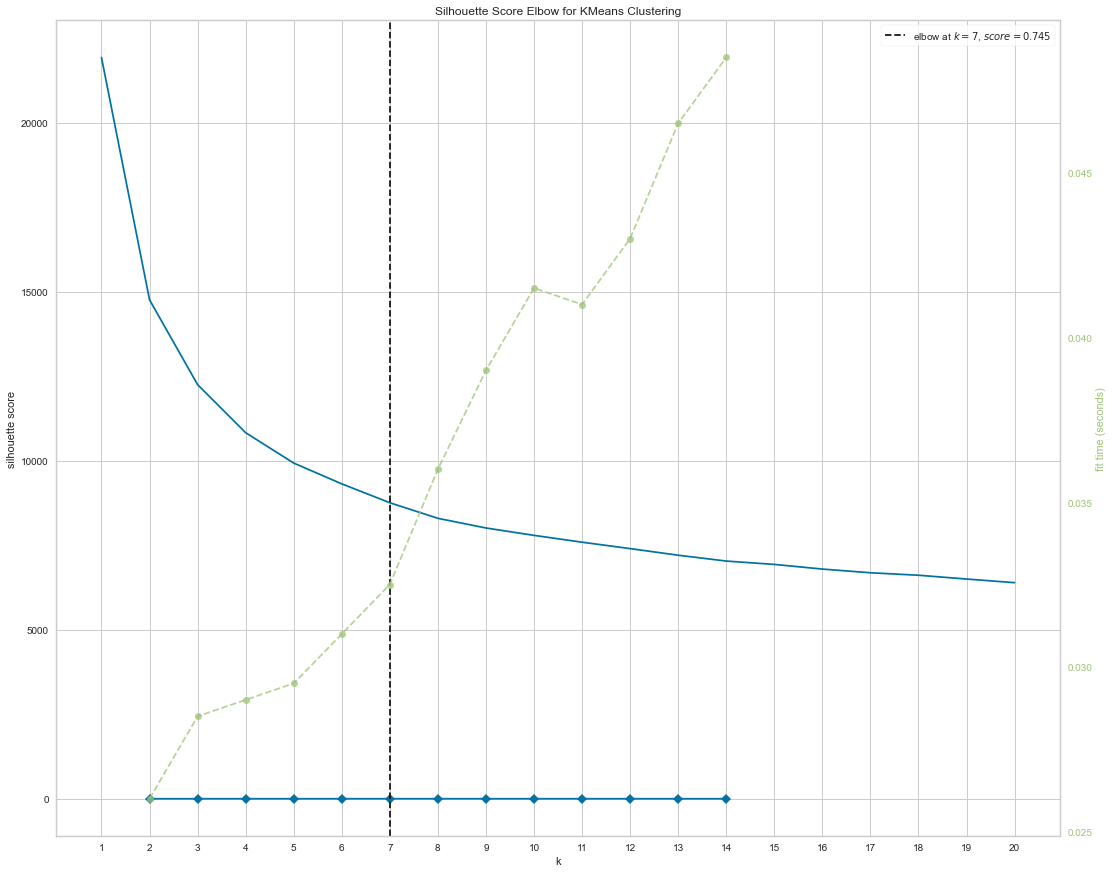

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [109]:


plt.plot(range(1,21),inertias)
plt.xticks(range(1,21));

X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette') #model for a range of K values from 1 to 21
visualizer.fit(X)        
visualizer.show()        



## Probamos otra forma de clustering

1. Elegimos las principales caracteristicas por las que queremos agrupar a los jugadores

In [ ]:
df_nba_cambios

,rango,jugador,posicion,edad,equipo,partidos_jugados,partidos_iniciados,minutos_jugados,tiros_campo,intentos_campo,tiros_campo_porc,tiros_triples,intentos_triple,triples_porc,tiros_dobles,intentos_dobles,dobles_porc,tiros_efectivo_porc,tiros_libres,intentos_tiros_libres,tiros_libres_porc,rebotes_ofensivos,rebotes_defensivos,total_rebotes,asistencias,robos,bloqueos,perdidas_balon,faltas_personales,total_puntos
0,1,precious_achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,0.8,2.1,0.359,2.9,6.1,0.468,0.486,1.1,1.8,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,steven_adams,C,28,MEM,76,75,26.3,2.8,5.1,0.547,0.0,0.0,0.000,2.8,5.0,0.548,0.547,1.4,2.6,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,bam_adebayo,C,24,MIA,56,56,32.6,7.3,13.0,0.557,0.0,0.1,0.000,7.3,12.9,0.562,0.557,4.6,6.1,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,santi_aldama,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,0.2,1.5,0.125,1.5,2.6,0.560,0.424,0.6,1.0,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,lamarcus_aldridge,C,36,BRK,47,12,22.3,5.4,9.7,0.550,0.3,1.0,0.304,5.1,8.8,0.578,0.566,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,thaddeus_young,PF,33,TOR,26,0,18.3,2.6,5.5,0.465,0.7,1.7,0.395,1.9,3.9,0.495,0.524,0.5,1.0,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
808,602,trae_young,PG,23,ATL,76,76,34.9,9.4,20.3,0.460,3.1,8.0,0.382,6.3,12.3,0.512,0.536,6.6,7.3,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
809,603,omer_yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,0.526,0.0,0.2,0.091,2.3,4.2,0.547,0.528,0.7,1.1,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
810,604,cody_zeller,C,29,POR,27,0,13.1,1.9,3.3,0.567,0.0,0.1,0.000,1.9,3.2,0.593,0.567,1.4,1.8,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


In [ ]:
df_copia = df_nba_cambios.copy()

In [ ]:
df_copia = df_copia[['posicion','tiros_triples','tiros_dobles','tiros_libres','total_rebotes','asistencias','robos','bloqueos','total_puntos']]

In [ ]:
df_copia

,posicion,tiros_triples,tiros_dobles,tiros_libres,total_rebotes,asistencias,robos,bloqueos,total_puntos
0,C,0.8,2.9,1.1,6.5,1.1,0.5,0.6,9.1
1,C,0.0,2.8,1.4,10.0,3.4,0.9,0.8,6.9
2,C,0.0,7.3,4.6,10.1,3.4,1.4,0.8,19.1
3,PF,0.2,1.5,0.6,2.7,0.7,0.2,0.3,4.1
4,C,0.3,5.1,1.9,5.5,0.9,0.3,1.0,12.9
...,...,...,...,...,...,...,...,...,...
807,PF,0.7,1.9,0.5,4.4,1.7,1.2,0.4,6.3
808,PG,3.1,6.3,6.6,3.7,9.7,0.9,0.1,28.4
809,C,0.0,2.3,0.7,5.3,0.9,0.3,0.4,5.3
810,C,0.0,1.9,1.4,4.6,0.8,0.3,0.2,5.2


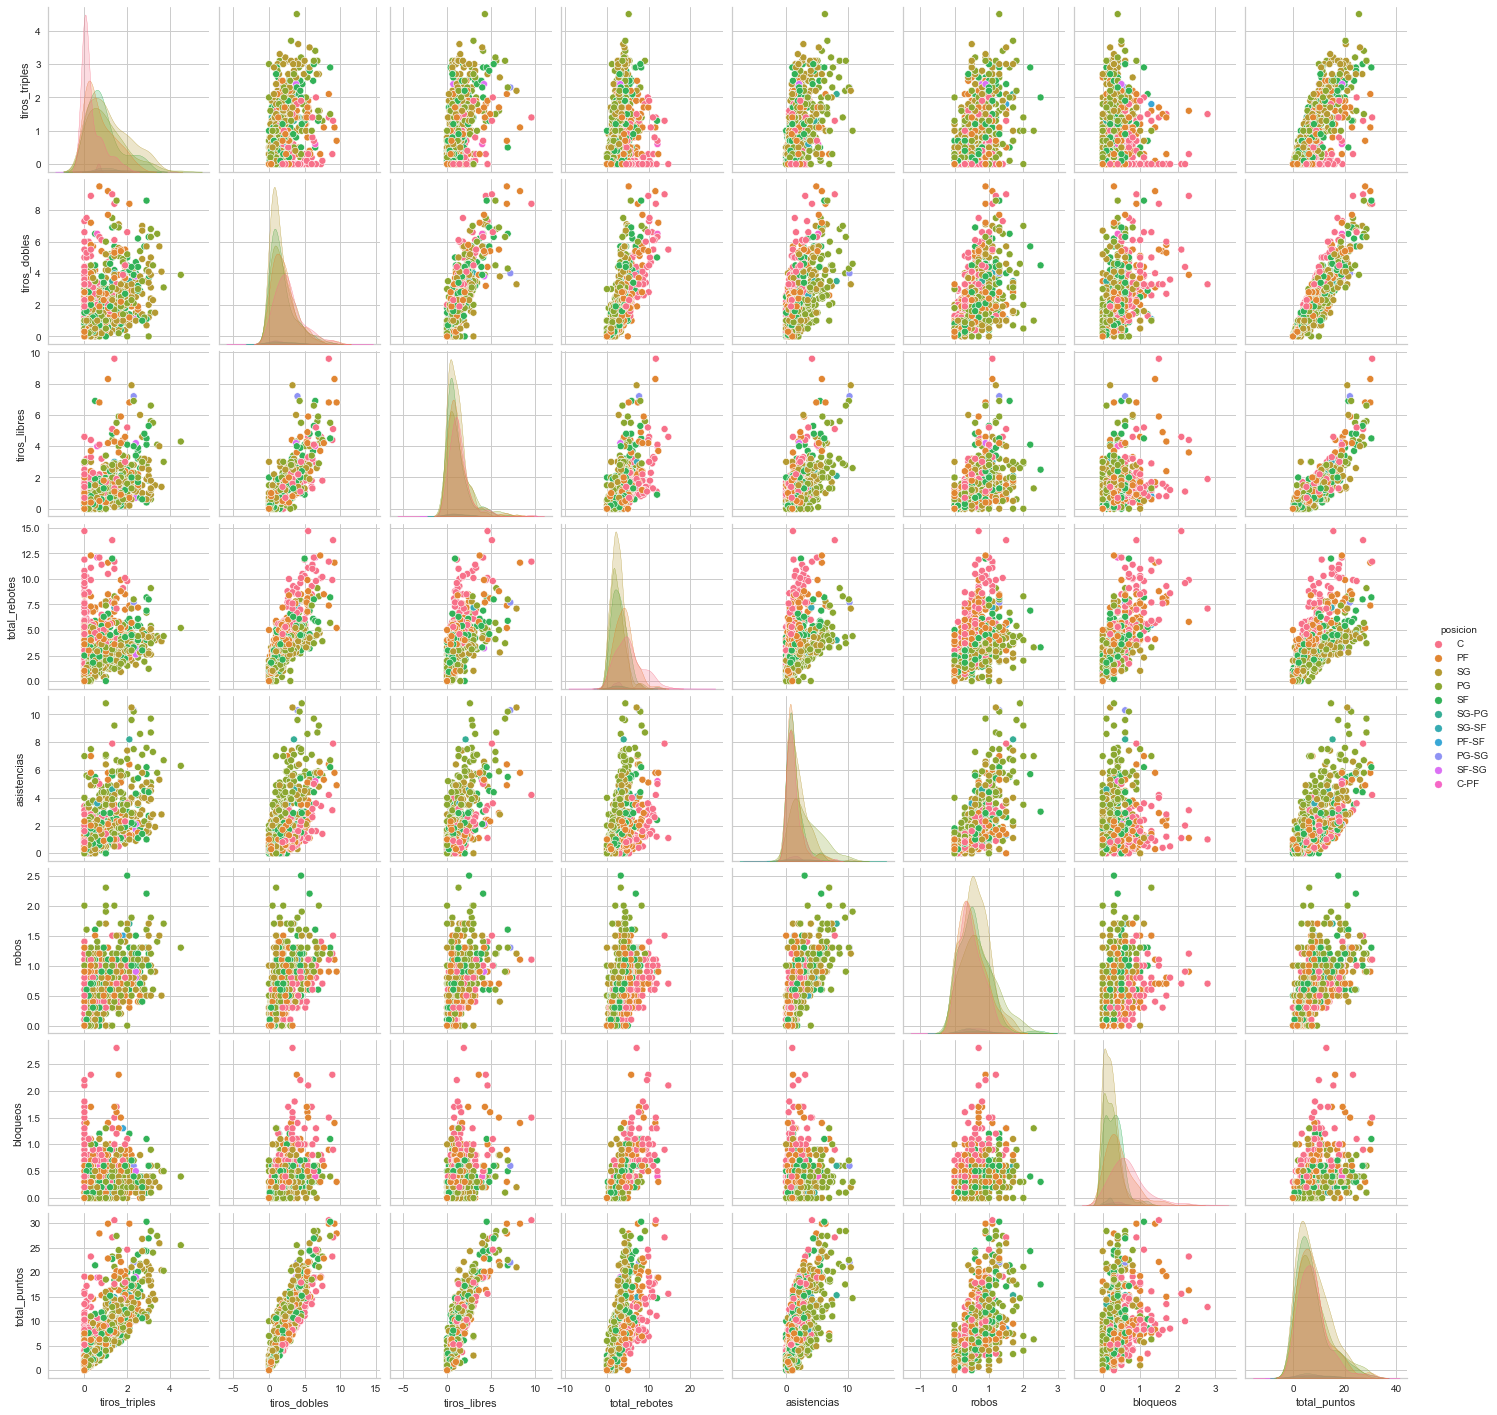

In [ ]:
sns.pairplot(df_copia, hue="posicion")

- Vemos que hay 11 diferentes posiciones y algunas muy parecidas, por lo que podriamos agruparlas en menos.

In [ ]:
grupos = {
    "C":['C', 'C-PF'],
    "PF":["PF", 'PF-SF'],
    "SG":['SG', 'SG-PG', 'SG-SF'],
    "PG":['PG', 'PG-SG'],
    "SF":['SF', 'SF-SG']}

In [ ]:
def posicion_reducida(prod, cat=grupos):
    for k, v in cat.items():
        if prod in v:
            return k
    return "other"

In [ ]:
df_copia["posicion_reducida"] = df_copia["posicion"].apply(posicion_reducida)

In [ ]:
df_copia = df_copia.drop(columns=["posicion"])

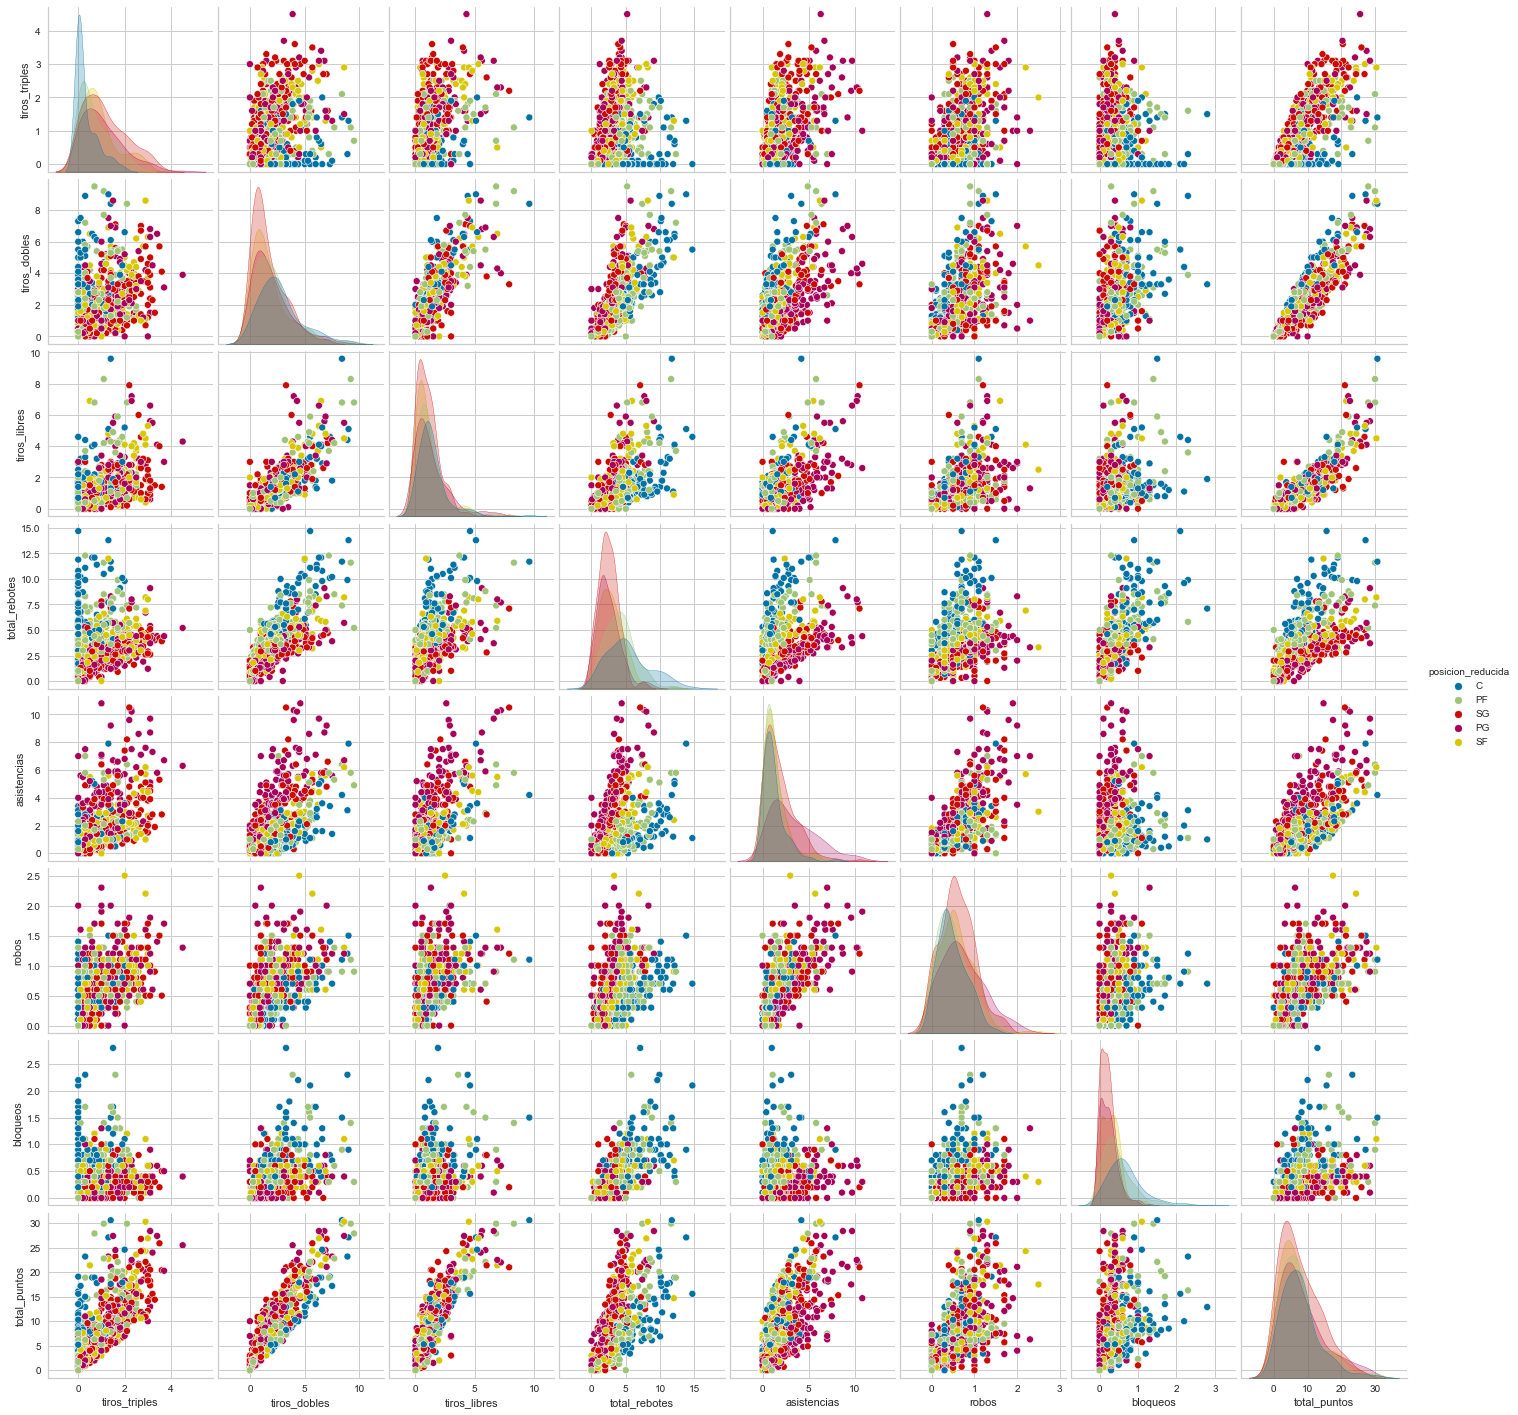

In [ ]:
sns.pairplot(df_copia, hue="posicion_reducida")

## Codificamos nuestra variable categórica

In [ ]:
mapa = {'C':1,
        'PF':2,
        'SG':3,
        'PG':4,
        'SF':5}

In [ ]:
df_copia["posicion_cod"] = df_copia["posicion_reducida"].map(mapa)

In [ ]:
df_copia

,tiros_triples,tiros_dobles,tiros_libres,total_rebotes,asistencias,robos,bloqueos,total_puntos,posicion_reducida,posicion_cod
0,0.8,2.9,1.1,6.5,1.1,0.5,0.6,9.1,C,1
1,0.0,2.8,1.4,10.0,3.4,0.9,0.8,6.9,C,1
2,0.0,7.3,4.6,10.1,3.4,1.4,0.8,19.1,C,1
3,0.2,1.5,0.6,2.7,0.7,0.2,0.3,4.1,PF,2
4,0.3,5.1,1.9,5.5,0.9,0.3,1.0,12.9,C,1
...,...,...,...,...,...,...,...,...,...,...
807,0.7,1.9,0.5,4.4,1.7,1.2,0.4,6.3,PF,2
808,3.1,6.3,6.6,3.7,9.7,0.9,0.1,28.4,PG,4
809,0.0,2.3,0.7,5.3,0.9,0.3,0.4,5.3,C,1
810,0.0,1.9,1.4,4.6,0.8,0.3,0.2,5.2,C,1


In [ ]:
km = KMeans(n_clusters=5)
y_predicted = km.fit_predict(df_copia[['posicion_cod']])
y_predicted

array([1, 1, 1, 4, 1, 2, 2, 2, 2, 1, 0, 3, 3, 3, 4, 4, 3, 4, 0, 3, 0, 3,
       0, 0, 0, 3, 2, 1, 1, 4, 4, 4, 0, 0, 1, 3, 3, 0, 4, 4, 3, 2, 3, 4,
       3, 4, 3, 4, 2, 2, 1, 3, 3, 3, 4, 4, 4, 0, 3, 1, 1, 1, 1, 0, 3, 2,
       4, 4, 3, 3, 2, 2, 4, 2, 2, 1, 3, 3, 4, 3, 0, 2, 2, 0, 3, 3, 2, 2,
       2, 2, 3, 2, 3, 3, 1, 1, 1, 2, 3, 0, 1, 0, 3, 0, 2, 2, 3, 4, 2, 0,
       4, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 0, 3, 3, 0, 4, 2, 4, 4,
       2, 1, 2, 4, 4, 0, 0, 2, 4, 0, 4, 1, 1, 1, 4, 4, 3, 3, 3, 3, 4, 2,
       2, 0, 2, 2, 2, 0, 1, 1, 2, 4, 1, 4, 1, 4, 4, 1, 2, 1, 0, 0, 0, 2,
       2, 2, 0, 3, 2, 2, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 2, 0, 0,
       4, 1, 2, 2, 3, 2, 3, 2, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4,
       4, 4, 4, 0, 2, 2, 2, 3, 0, 2, 0, 2, 0, 0, 0, 1, 0, 4, 4, 4, 4, 1,
       4, 2, 2, 2, 0, 2, 4, 1, 4, 3, 1, 2, 0, 4, 4, 1, 0, 2, 4, 2, 0, 4,
       0, 3, 4, 2, 4, 3, 1, 2, 4, 2, 2, 4, 2, 2, 0, 2, 2, 2, 0, 0, 2, 3,
       0, 1, 1, 1, 2, 3, 4, 2, 2, 2, 3, 1, 1, 3, 1,

In [ ]:
df_copia['cluster']=y_predicted
df_copia.head()

,tiros_triples,tiros_dobles,tiros_libres,total_rebotes,asistencias,robos,bloqueos,total_puntos,posicion_reducida,posicion_cod,cluster
0,0.8,2.9,1.1,6.5,1.1,0.5,0.6,9.1,C,1,1
1,0.0,2.8,1.4,10.0,3.4,0.9,0.8,6.9,C,1,1
2,0.0,7.3,4.6,10.1,3.4,1.4,0.8,19.1,C,1,1
3,0.2,1.5,0.6,2.7,0.7,0.2,0.3,4.1,PF,2,4
4,0.3,5.1,1.9,5.5,0.9,0.3,1.0,12.9,C,1,1


In [ ]:
km.cluster_centers_

array([[4.],
       [1.],
       [3.],
       [5.],
       [2.]])

In [ ]:
df_copia.dtypes

tiros_triples        float64
tiros_dobles         float64
tiros_libres         float64
total_rebotes        float64
asistencias          float64
robos                float64
bloqueos             float64
total_puntos         float64
posicion_reducida     object
posicion_cod           int64
cluster                int32
dtype: object

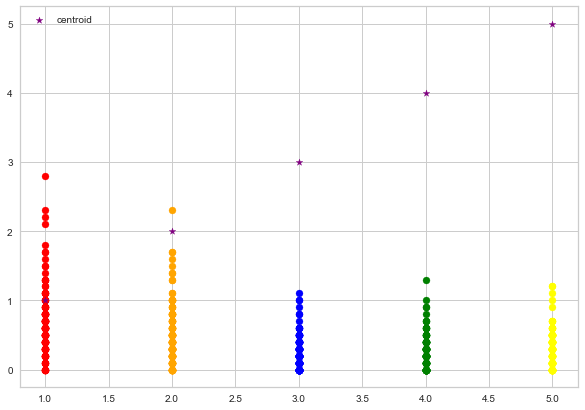

In [ ]:
plt.figure(figsize=(10,7))

df1 = df_copia[df_copia.cluster==0]
df2 = df_copia[df_copia.cluster==1]
df3 = df_copia[df_copia.cluster==2]
df4 = df_copia[df_copia.cluster==3]
df5 = df_copia[df_copia.cluster==4]
plt.scatter(df1.posicion_cod,df1['bloqueos'],color='green')
plt.scatter(df2.posicion_cod,df2['bloqueos'],color='red')
plt.scatter(df3.posicion_cod,df3['bloqueos'],color='blue')
plt.scatter(df4.posicion_cod,df4['bloqueos'],color='yellow')
plt.scatter(df5.posicion_cod,df5['bloqueos'],color='orange')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,0],color='purple',marker='*',label='centroid')
plt.legend()